# Pleiades Membership Identification using Gaussian Mixture Models

In [ ]:
#if running in google colab, uncomment the following:
#!git clone https://github.com/kevinmcmanus/cas-tau.git
#!pip install astroquery
#!pip install pyvo

In [2]:
# necessary modules

import sys
sys.path.append('./cas-tau/src')
sys.path.append('./src')

import astropy.coordinates as coord
from astropy.table import QTable, Table, vstack

import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
import pandas as pd
import numpy as np
import pickle
import os

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns

%matplotlib inline

#from cluster import cluster as cl
from fieldstars import fieldstars as fs

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [3]:
from astropy.visualization import quantity_support
quantity_support() 

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x182823deec8>

## Get Simbad Catalog Entry for Pleiades (and some other open clusters)

In [4]:
clusters = ['Blanco 1',
 'Collinder 140',
 'Coma Berenices Cluster',
 'Hyades',
 'IC 2391',
 'IC 2602',
 'IC 4665',
 'NGC 2232',
 'NGC 2422',
 'NGC 2451A',
 'NGC 2516',
 'NGC 2547',
 'NGC 3532',
 'NGC 6475',
 'NGC 6633',
 'NGC 7092',
 'Pleiades',
 'Praesepe',
 'alpha Per']

In [5]:
# set up the Simbad query
from astroquery.simbad import Simbad
from astropy.time import Time
mySimbad = Simbad()
mySimbad.add_votable_fields('parallax', 'pm','velocity','typed_id')
mySimbad.get_votable_fields()


['main_id', 'coordinates', 'parallax', 'pm', 'velocity', 'typed_id']

In [6]:
#from astropy.table import Table, vstack
res_table = vstack([mySimbad.query_object(c) for c in clusters],join_type='exact')


In [7]:
#fix the Simbad result to a more usable form
cluster_info=Table(res_table['TYPED_ID', 'PLX_VALUE', 'PLX_PREC','RA', 'RA_PREC', 'DEC', 'DEC_PREC',
                            'PMRA', 'PMDEC', 'RVZ_RADVEL', 'RVZ_ERROR'])

#gotta be a better way to do this:
cluster_info['TYPED_ID'] = [c.decode('utf-8') for c in cluster_info['TYPED_ID']]

#rename the columns to look like Gaia
cluster_info.rename_column('TYPED_ID','cluster')
cluster_info.rename_column('PLX_VALUE','parallax')
cluster_info.rename_column('PLX_PREC', 'parallax_error')
cluster_info.rename_column('RA', 'ra')
cluster_info.rename_column('RA_PREC','ra_error')
cluster_info.rename_column('DEC', 'dec')
cluster_info.rename_column('DEC_PREC','dec_error')
cluster_info.rename_column('PMRA', 'pmra')
cluster_info.rename_column('PMDEC', 'pmdec')
cluster_info.rename_column('RVZ_RADVEL','radial_velocity')
cluster_info.rename_column('RVZ_ERROR', 'rv_error')

#unmask the columns
cluster_info = cluster_info.filled() 


#index on the cluster name
cluster_info.add_index('cluster')

# coordinates,  note the update to J2015.5 to match with Gaia
cluster_info['coords'] = \
    SkyCoord(ra = cluster_info['ra'],
        dec = cluster_info['dec'], unit = (u.hour, u.deg),
        obstime = 'J2000',  #simbad returns J2000 coords
        distance = coord.Distance(parallax=Quantity(cluster_info['parallax'])),
        pm_ra_cosdec = cluster_info['pmra'],
        pm_dec = cluster_info['pmdec'],
        radial_velocity = cluster_info['radial_velocity']).apply_space_motion(new_obstime=Time('2015.5',format='decimalyear'))

In [8]:
cluster_info.loc['Pleiades']

cluster,parallax,parallax_error,ra,ra_error,dec,dec_error,pmra,pmdec,radial_velocity,rv_error,coords
,mas,,"""h:m:s""",,"""d:m:s""",,mas / yr,mas / yr,km / s,km / s,"deg,deg,pc"
str22,float64,int16,str13,int16,str13,int16,float64,float64,float64,float32,object
Pleiades,7.364,3,03 47 00,4,+24 07.0,4,19.997,-45.548,5.650,0.090,"56.75009432548025,24.11647057028541,135.7958527032827"


## Get List of Known  Cluster Members

[Abstract](http://simbad.u-strasbg.fr/simbad/sim-ref?bibcode=2018A%26A...616A..10G)

In [9]:
#Get the cluster membership list from the study
members = pd.read_csv('ftp://cdsarc.u-strasbg.fr/pub/cats/J/A+A/616/A10/tablea1a.dat',
                      delim_whitespace=True,
                      header=None, index_col=None,
                      names = ['SourceID', 'Cluster', 'RAdeg', 'DEdeg', 'Gmag', 'plx', 'e_plx'])
members.set_index('SourceID', inplace=True)

In [10]:
#create map to Simbad cluster names
members.Cluster.unique()

array(['Hyades', 'ComaBer', 'Pleiades', 'Praesepe', 'alphaPer', 'IC2391',
       'IC2602', 'Blanco1', 'NGC2451'], dtype=object)

In [11]:
name_mapper = {'Hyades': 'Hyades',
               'ComaBer': 'Coma Berenices Cluster',
               'Pleiades': 'Pleiades',
               'Praesepe': 'Praesepe',
               'alphaPer': 'alpha Per',
               'IC2391': 'IC 2391',
               'IC2602': 'IC 2602',
               'Blanco1': 'Blanco 1',
               'NGC2451': 'NGC 2451A'}

In [12]:
members['SimbadCluster'] = members.Cluster.apply(lambda c:name_mapper[c])

In [13]:
members.head()

,Cluster,RAdeg,DEdeg,Gmag,plx,e_plx,SimbadCluster
SourceID,,,,,,,
49520255665123328,Hyades,64.87461,21.75372,12.861,20.866,0.033,Hyades
49729231594420096,Hyades,60.20378,18.19388,5.790,21.789,0.045,Hyades
51383893515451392,Hyades,59.80696,20.42805,12.570,22.737,0.006,Hyades
145373377272257664,Hyades,66.06127,21.73605,6.990,23.109,0.003,Hyades
145391484855481344,Hyades,67.00371,21.61972,5.643,19.968,0.067,Hyades


In [14]:
#get Astropy SkyCoords for each cluster member
members['coords'] = SkyCoord(ra = np.array(members.RAdeg)*u.degree,
        dec = np.array(members.DEdeg)*u.degree,
        obstime = Time('2015.5',format='decimalyear'),  #Gaia ref epoch is 2015.5
        distance = coord.Distance(parallax=Quantity(np.array(members.plx)*u.mas)))


In [15]:
#distance of each star from its cluster center
members['dist_c3d']=[s[1].coords.separation_3d(cluster_info.loc[s[1].SimbadCluster]['coords']) for s in members.iterrows()]

#convert to dimensionless scalar for plotting purposes (Grrrr)
members['dist_c3d_nq'] = Quantity(members.dist_c3d, unit=u.pc).value

#also get out distance from earth/sun
members['r_est'] = [s.distance.value for s in members.coords]

### Cluster Distance from Sun

Text(0.5, 1.0, 'Member Distance from Sun')

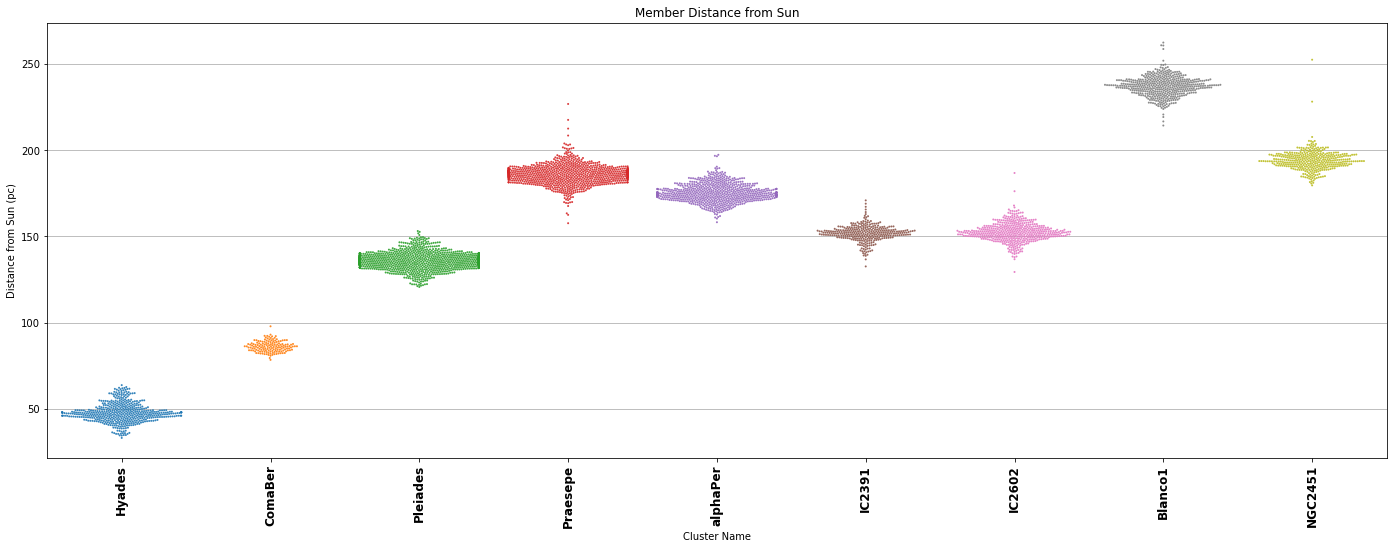

In [16]:
fig = plt.figure(figsize=(24,8))
ax = fig.add_subplot(1,1,1)
sns.swarmplot(x="Cluster",y='r_est', data=members,ax=ax, s=2, alpha=0.9)
zz=plt.xticks(rotation=90)
ax.set_ylabel('Distance from Sun (pc)')
ax.set_xticklabels(ax.get_xticklabels(),fontdict={'fontsize':12, 'fontweight':'bold'})
ax.set_xlabel('Cluster Name')
ax.grid(axis='y')
ax.set_title('Member Distance from Sun')

### Cluster Member Distance from Cluster Center

Text(0.5, 1.0, 'Member Distance from Cluster Center')

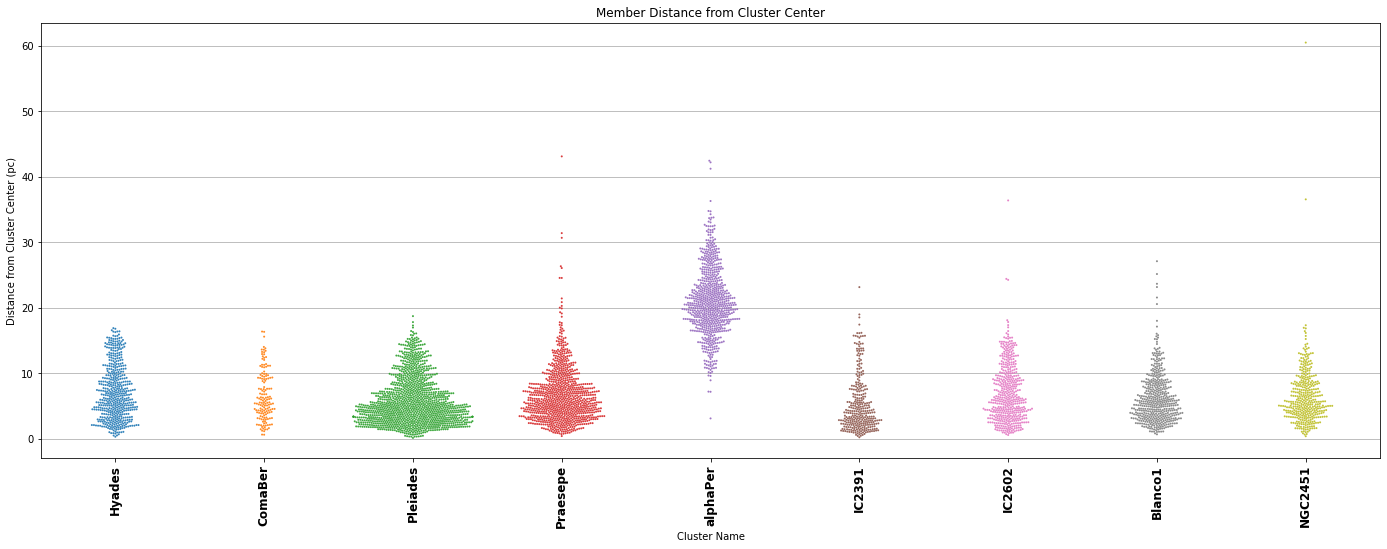

In [17]:
fig = plt.figure(figsize=(24,8))
ax = fig.add_subplot(1,1,1)
sns.swarmplot(x="Cluster",y='dist_c3d_nq', data=members,ax=ax,s=2,alpha=0.9)
zz=plt.xticks(rotation=90)
ax.set_ylabel('Distance from Cluster Center (pc)')
ax.set_xticklabels(ax.get_xticklabels(),fontdict={'fontsize':12, 'fontweight':'bold'})
ax.set_xlabel('Cluster Name')
ax.grid(axis='y')
ax.set_title('Member Distance from Cluster Center')

In [18]:
# Just interested in Pleiades, for now

pleiades_true = members.query('Cluster == \'Pleiades\'')

In [19]:
len(pleiades_true)

1326

The Pleiades contains 1326 members according to the Gaia Collaboration.

In [20]:
# fetch the gaia records for the known members:
pleiades_gaia = fs('Pleiades: Known Members')
pleiades_gaia.from_source_idlist(pleiades_true.index.to_list())


INFO: Query finished. [astroquery.utils.tap.core]


In [21]:
pleiades_gaia.objs.head()

,source_id,ra,dec,parallax,pmra,pmdec,radial_velocity,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,e_bp_min_rp_val,a_g_val,r_est
source,,,,,,,,,,,,,
51391658816356608,51391658816356608,59.493780,20.405304,7.278419,18.246316,-46.912926,NaN,16.961014,18.774172,15.654202,0.4390,0.7490,136.913356
51391418298186368,51391418298186368,59.532088,20.393808,7.217385,18.343572,-44.610591,NaN,16.868746,18.594454,15.587454,0.3237,0.5160,138.078223
50976077779666688,50976077779666688,57.043116,19.302309,7.646098,21.057506,-46.628872,7.792545,12.729138,13.437214,11.930278,0.1297,0.1900,130.297387
51303388648134400,51303388648134400,58.658450,19.906175,7.885402,20.017045,-48.288309,NaN,16.396292,18.132336,15.106649,0.4872,0.8635,126.388703
51284971828429440,51284971828429440,59.285910,20.128423,7.161974,18.595580,-44.977433,NaN,17.950144,19.791430,16.588367,NaN,NaN,139.210940


In [22]:
len(pleiades_true),len(pleiades_gaia.objs)

(1326, 1326)

### Pleiades HR Diagram

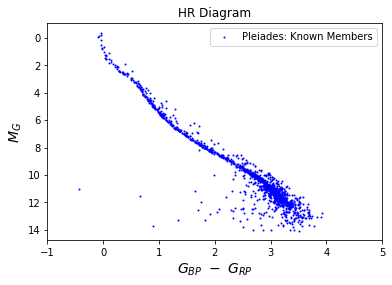

In [23]:
pleiades_gaia.plot_hrdiagram()

## Cone Search Around Pleiades' Center

In [24]:
#Grab at most 100000 stars in a 3 degree circle around the Pleiades' center
pleiades_fs = fs('Pleiades: Field Stars')
pleiades_fs.conesearch(ra=cluster_info.loc['Pleiades']['coords'].ra, dec=cluster_info.loc['Pleiades']['coords'].dec, radius=3*u.degree, maxrec=100000)

INFO: Query finished. [astroquery.utils.tap.core]


In [25]:
len(pleiades_fs.objs)

24623

In [26]:
print(pleiades_fs.tap_query_string)

SELECT 
		gs.source_id
		,gs.ra
		,gs.dec
		,gs.parallax
		,gs.pmra
		,gs.pmdec
		,gs.radial_velocity
		,gs.phot_g_mean_mag
		,gs.phot_bp_mean_mag
		,gs.phot_rp_mean_mag
		,gs.e_bp_min_rp_val
		,gs.a_g_val, gd.r_est
FROM external.gaiadr2_geometric_distance gd
	INNER JOIN gaiadr2.gaia_source gs using (source_id) 
WHERE 
	CONTAINS(POINT('', gs.ra, gs.dec), 
		CIRCLE('', 56.75009432548025, 24.11647057028541, 3.0)) = 1  AND parallax_over_error > 10 AND phot_g_mean_flux_over_error>50 AND phot_rp_mean_flux_over_error>20 AND phot_bp_mean_flux_over_error>20 AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2) AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2) AND visibility_periods_used>8 AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))


## How many of the known members did our query find?

In [27]:
pleiades_all = pleiades_fs.merge(pleiades_gaia)

In [28]:
pleiades_all.objs.head()

,source_id,_merge,which,ra,dec,parallax,pmra,pmdec,radial_velocity,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,e_bp_min_rp_val,a_g_val,r_est
45022222315428608,4.502222e+16,right_only,Pleiades: Known Members,56.117101,19.184820,6.895280,18.879784,-41.231841,3.243060,11.556369,12.090134,10.888288,0.259,0.538,144.428762
49809495943068288,4.980950e+16,right_only,Pleiades: Known Members,59.457284,18.562188,7.694013,20.279658,-47.180525,8.910763,11.195218,11.656753,10.616302,0.021,0.041,129.491599
50229028348709248,5.022903e+16,right_only,Pleiades: Known Members,60.349562,19.142157,7.590517,19.015832,-47.092572,NaN,16.678955,18.445066,15.396044,0.346,0.590,131.281717
50691613506647680,5.069161e+16,right_only,Pleiades: Known Members,57.452753,18.636455,7.391869,20.912397,-44.363314,NaN,18.074593,20.119471,16.686657,NaN,NaN,134.948877
50706216395526144,5.070622e+16,right_only,Pleiades: Known Members,57.884475,18.666056,7.759876,19.832347,-47.475987,NaN,17.253996,19.062082,15.912800,NaN,NaN,128.471145


In [29]:
pleiades_all.objs.which.value_counts()

Pleiades: Field Stars      23797
both                         826
Pleiades: Known Members      500
Name: which, dtype: int64

Of the 1326 stars known to be in the Pleiades, our cone search query found 826 of them and missed 500. In addition, the cone search returned 23,797 other stars.

The plot below shows the results. The blue dots are the 826 known members returned in the query results, the 500 red dots are the ones the query missed.  Many of  the red dots are outside of the cone search radius, however many are inside.  THose inside the query radius were possibly excluded from the search results because they did not meet the observational quality constraints of the query.

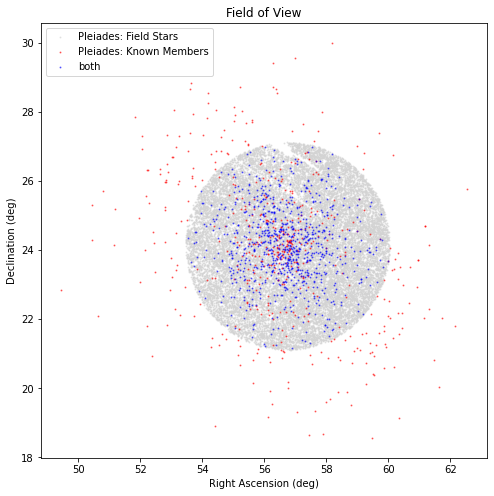

In [30]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

for cw in [('lightgrey','Pleiades: Field Stars'), ('red', 'Pleiades: Known Members'),('blue','both')]:
    sub = pleiades_all.objs.query('which == @cw[1]')
    pcm=ax.scatter(sub.ra, sub.dec,s=1, alpha=0.5, color=cw[0], label=cw[1])

ax.set_title('Field of View')
ax.set_ylabel('Declination (deg)')
ax.set_xlabel('Right Ascension (deg)')
ax.legend()

## Exploratory Data Analysis of the Query Results

In [31]:
pleiades_fs_coords = pleiades_fs.get_coords()

In [32]:
import matplotlib.colors as colors
cmap = plt.get_cmap('viridis')

### Distance Histogram

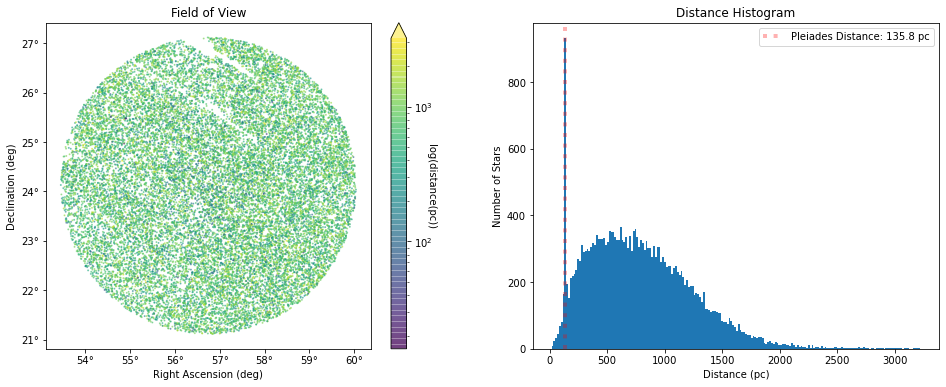

In [33]:
fig = plt.figure(figsize=(16,6))
ax = fig.subplots(1,2)

vmin = pleiades_fs_coords.distance.min().value; vmax = pleiades_fs_coords.distance.max().value
pcm=ax[0].scatter(pleiades_fs_coords.ra, pleiades_fs_coords.dec,s=1, alpha=0.5,
                  c=pleiades_fs_coords.distance.value, cmap=cmap,
                  norm=colors.LogNorm(vmin=vmin, vmax=vmax))
ax[0].set_title('Field of View')
ax[0].set_ylabel('Declination (deg)')
ax[0].set_xlabel('Right Ascension (deg)')
cb=fig.colorbar(pcm,ax=ax[0], extend='max')

cb.ax.set_ylabel('log(distance(pc))',rotation=270)
dist = cluster_info.loc['Pleiades']['coords'].distance
ax[1].axvline(dist, color='red', lw=4,ls=':',
              label=f'Pleiades Distance: {dist:.1f}', alpha=0.3)
zz=ax[1].hist(pleiades_fs.objs.r_est, bins=200, histtype='stepfilled')

ax[1].set_ylabel('Number of Stars')
ax[1].set_xlabel('Distance (pc)')
#ax[1].set_xscale('log')
ax[1].set_title('Distance Histogram')
ax[1].legend()


In [34]:
cluster_info.loc['Pleiades']['pmra'], cluster_info.loc['Pleiades']['pmdec']

(19.997, -45.548)

### Proper Motions at Three Zoom Levels

Text(0.5, 0.98, 'Proper Motions - 3 Zoom Levels')

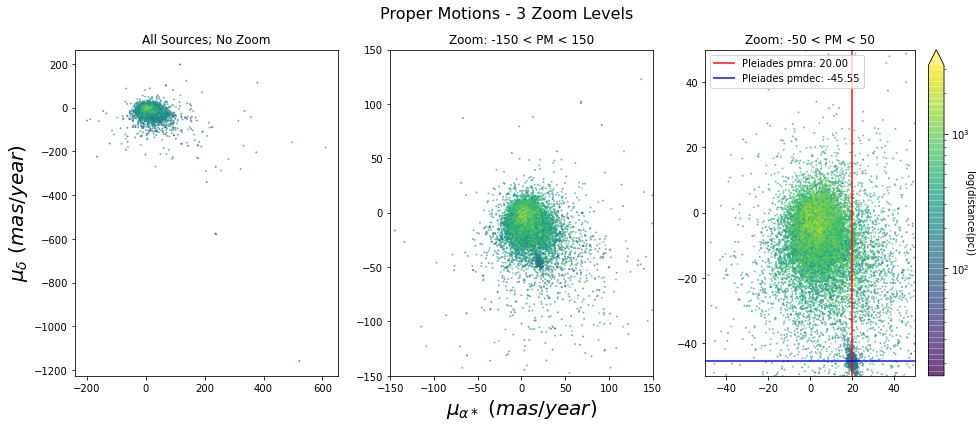

In [35]:

r_min = pleiades_fs.objs.r_est.min(); r_max=pleiades_fs.objs.r_est.max()

fig = plt.figure(figsize=(16,6))
ax = fig.subplots(1,3)



ax[0].scatter(x='pmra',y='pmdec',s=1, c='r_est',data=pleiades_fs.objs, alpha=0.5, cmap=cmap,
             norm=colors.LogNorm(vmin=vmin, vmax=vmax))
ax[0].set_title('All Sources; No Zoom')
ax[0].set_ylabel(r'$\mu_{\delta}\ (mas/year)$', fontsize=20)

ax[1].scatter(x='pmra',y='pmdec',s=1, c='r_est', data=pleiades_fs.objs, alpha=0.5, cmap=cmap,
             norm=colors.LogNorm(vmin=vmin, vmax=vmax))
ax[1].set_ylim(-150,150)
ax[1].set_xlim(-150,150)
ax[1].set_xlabel(r'$\mu_{\alpha *}\ (mas/year)$',fontsize=20)
ax[1].set_title('Zoom: -150 < PM < 150')

cb = ax[2].scatter(x='pmra',y='pmdec',s=1, c='r_est', data=pleiades_fs.objs,  alpha=0.5, cmap=cmap,
                  norm=colors.LogNorm(vmin=vmin, vmax=vmax), label=None)
ax[2].set_ylim(-50,50)
ax[2].set_xlim(-50,50)
pmra = cluster_info.loc['Pleiades']['pmra']
pmdec = cluster_info.loc['Pleiades']['pmdec']
ax[2].axvline(pmra, color='red', lw=2,#ls=':',
              label=f'Pleiades pmra: {pmra:.2f}', alpha=0.7)
ax[2].axhline(pmdec, color='blue', lw=2,#ls='-',
              label=f'Pleiades pmdec: {pmdec:.2f}', alpha=0.7)
ax[2].set_title('Zoom: -50 < PM < 50')
ax[2].legend(loc='upper left')
cb=fig.colorbar(cb,ax=ax[2], extend='max')

cb.ax.set_ylabel('log(distance(pc))',rotation=270)

fig.suptitle('Proper Motions - 3 Zoom Levels', fontsize=16)



./src\fieldstars.py:207: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = yax.pcolormesh(xi, yi, zi.reshape(xi.shape),cmap=cmap)


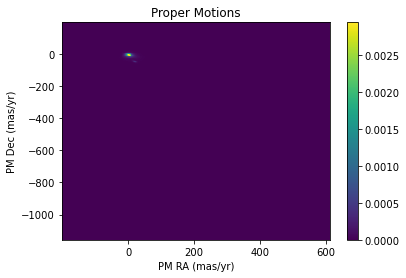

In [36]:
pleiades_fs.plot_motions()

### HR Diagram Pleiades' Known Members and Query Results

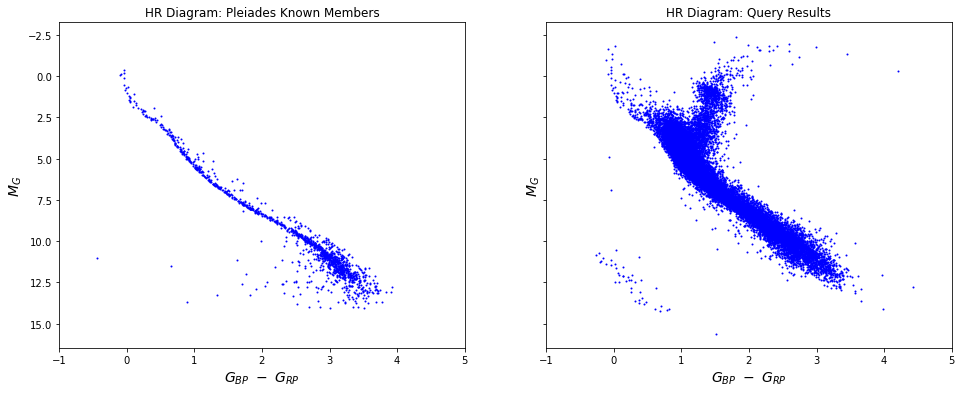

In [37]:
fig = plt.figure(figsize=(16,6))
ax = fig.subplots(1,2,sharey=True)
pleiades_gaia.plot_hrdiagram(ax=ax[0], title='HR Diagram: Pleiades Known Members')
pleiades_fs.plot_hrdiagram(ax=ax[1], title='HR Diagram: Query Results')

## Gaussian Mixture Model to Identify Members

In [38]:
import seaborn as sns

### Build Feature Matrix

In [39]:
#use cartesian coords along with PMs as feature matrix
feats = np.array([pleiades_fs_coords.cartesian.x,
                  pleiades_fs_coords.cartesian.y,
                  pleiades_fs_coords.cartesian.z,
                  pleiades_fs.objs.pmra,
                  pleiades_fs.objs.pmdec]).T

In [41]:
from sklearn import mixture

In [42]:
def get_bic(X, covar_type, n_components):
    gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=covar_type)
    gmm.fit(X)
    return gmm.bic(X)


### Grid Search over Covar Type and 8 Components

In [43]:
bic_df = pd.DataFrame([(cv,nc, get_bic(feats, cv, nc))  for cv in ['spherical','tied','diag','full'] for nc in range(1,9)],columns=['covar_type','n_components','BIC'])

C:\Users\kevin\Anaconda3\envs\astro\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


In [44]:
import seaborn as sns

<AxesSubplot:xlabel='n_components', ylabel='BIC'>

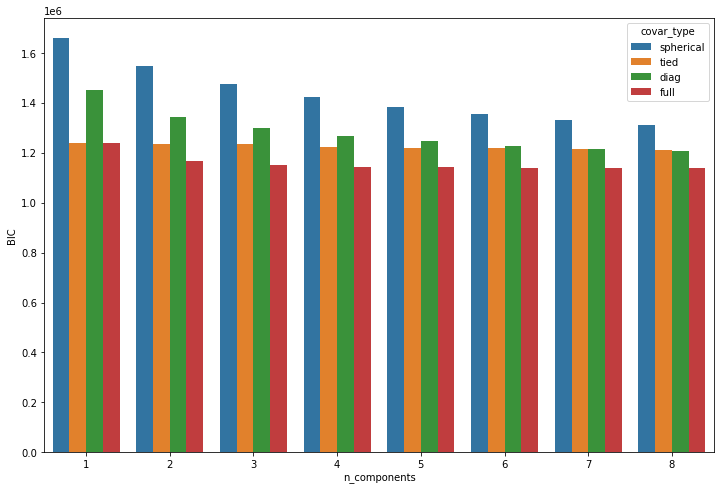

In [45]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
sns.barplot(x='n_components',y='BIC',hue="covar_type", data=bic_df)

### Find Model with Minimumm BIC

In [46]:
#get the covariance type and the number of components for the model with the minimum BIC
idx = bic_df.query('BIC == @bic_df.BIC.min()').index[0]
covar_type, n_components = bic_df.loc[idx][['covar_type', 'n_components']]

In [47]:
covar_type, n_components

('full', 8)

### Build Optimum Model (covar=Full, n_components=8)

In [48]:
gmm = mixture.GaussianMixture(covariance_type=covar_type, n_components=n_components)
gmm.fit(feats)

GaussianMixture(n_components=8)

### Label Each Star with the Cluster it Belongs To

In [49]:
pleiades_fs.objs['labels'] = gmm.predict(feats)


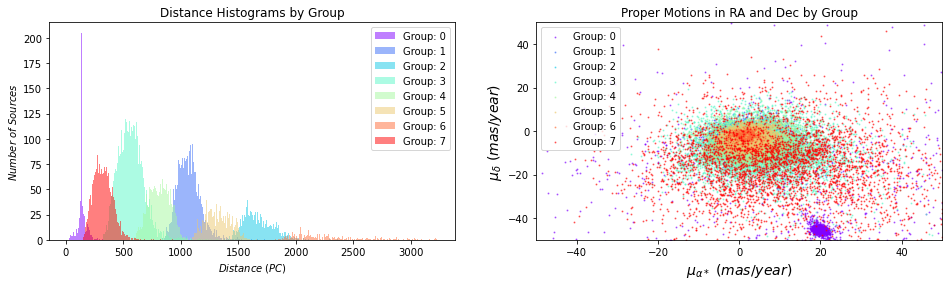

In [50]:


color=iter(cm.rainbow(np.linspace(0,1,n_components)))


fig = plt.figure(figsize=(16,4))
ax = fig.subplots(1,2)

for i in range(n_components):
    zz = ax[0].hist(pleiades_fs.objs.query('labels==@i').r_est,bins=200, histtype='stepfilled',alpha=0.5, density=False, color=next(color),label=f'Group: {i}')
ax[0].legend()
#ax[0].set_ylim(0,65)
ax[0].set_title('Distance Histograms by Group')
ax[0].set_xlabel('$Distance\ (PC)$')
ax[0].set_ylabel('$Number\ of\ Sources$')

color=iter(cm.rainbow(np.linspace(0,1,n_components)))
for i in range(n_components):
    cb = ax[1].scatter(x='pmra',y='pmdec',s=1,label=f'Group: {i}',
                data=pleiades_fs.objs.query('labels==@i'),  alpha=0.5,
                color = next(color))

ax[1].set_ylim(-50,50)
ax[1].set_xlim(-50,50)
ax[1].set_title('Proper Motions in RA and Dec by Group')


ax[1].set_ylabel(r'$\mu_{\delta}\ (mas/year)$', fontsize=14)
ax[1].set_xlabel(r'$\mu_{\alpha *}\ (mas/year)$',fontsize=14)
ax[1].legend(loc='upper left')

## Which Group (Cluster) Corresponds to the Pleiades?

In [51]:
#look up the position and motion info for the cluster center
cluster_info.loc['Pleiades']

cluster,parallax,parallax_error,ra,ra_error,dec,dec_error,pmra,pmdec,radial_velocity,rv_error,coords
,mas,,"""h:m:s""",,"""d:m:s""",,mas / yr,mas / yr,km / s,km / s,"deg,deg,pc"
str22,float64,int16,str13,int16,str13,int16,float64,float64,float64,float32,object
Pleiades,7.364,3,03 47 00,4,+24 07.0,4,19.997,-45.548,5.650,0.090,"56.75009432548025,24.11647057028541,135.7958527032827"


In [52]:
#Build a feature matrix (1 x 5) for the Pleiades cluster center
pleiades_feats = np.array([cluster_info.loc['Pleiades']['coords'].cartesian.x.value,
                           cluster_info.loc['Pleiades']['coords'].cartesian.y.value,
                           cluster_info.loc['Pleiades']['coords'].cartesian.z.value,
                           cluster_info.loc['Pleiades']['pmra'],
                           cluster_info.loc['Pleiades']['pmdec']]).reshape((1,5))

In [53]:
#run it through the model to see which cluster does the gmm place the pleiades center in?
pleiades_clust_id = gmm.predict(pleiades_feats)[0]

In [54]:
pleiades_clust_id 

0

In [55]:
gmm.predict_proba(pleiades_feats)

array([[9.73991303e-001, 2.87266055e-046, 4.80112503e-056,
        1.75100515e-009, 7.28058463e-028, 6.16080136e-065,
        2.81624121e-151, 2.60086948e-002]])

Pleaiades cluster center has a 0.97 probility of belonging to cluster \#5, a 0.026 probability of belonging to cluster \#0 and virtually zero probability of belonging to any of the others.

In [56]:
gmm.means_[pleiades_clust_id]

array([ 72.35907736, 110.23544633,  58.96025577,  26.25042814,
       -44.17031591])

Text(0.5, 0.98, 'Proper Motions - 3 Zoom Levels')

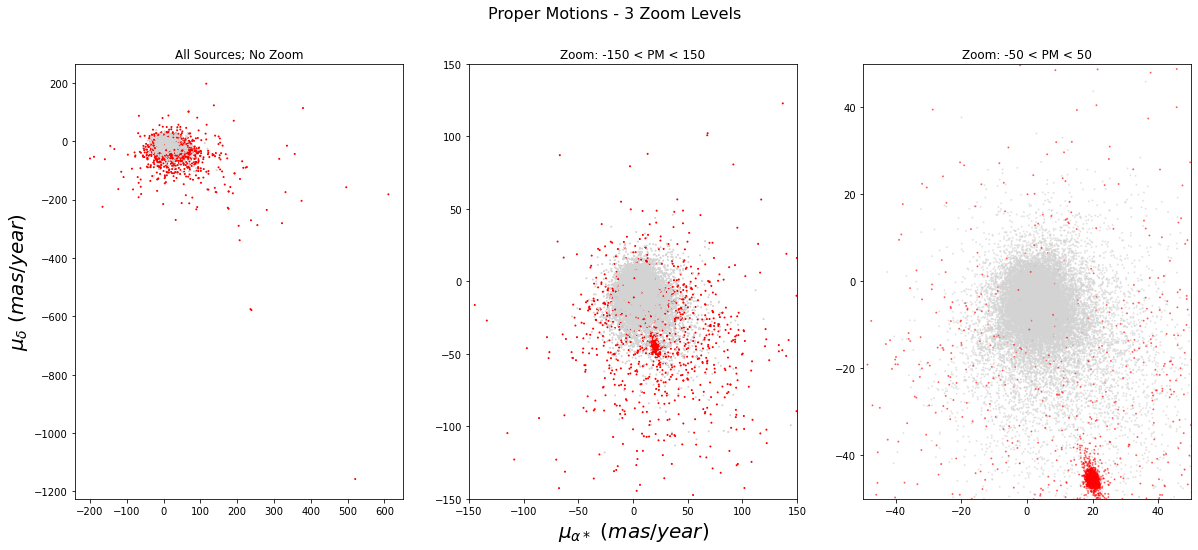

In [57]:
fig = plt.figure(figsize=(20,8))
ax = fig.subplots(1,3)

color_lambda = lambda l: 'red' if l==pleiades_clust_id else 'lightgray'


ax[0].scatter(x='pmra',y='pmdec',s=1,data=pleiades_fs.objs,
              facecolor=pleiades_fs.objs.labels.apply(color_lambda))
ax[0].set_title('All Sources; No Zoom')
ax[0].set_ylabel(r'$\mu_{\delta}\ (mas/year)$', fontsize=20)

ax[1].scatter(x='pmra',y='pmdec',s=1, data=pleiades_fs.objs,
              facecolor=pleiades_fs.objs.labels.apply(color_lambda))
ax[1].set_ylim(-150,150)
ax[1].set_xlim(-150,150)
ax[1].set_xlabel(r'$\mu_{\alpha *}\ (mas/year)$',fontsize=20)
ax[1].set_title('Zoom: -150 < PM < 150')

cb = ax[2].scatter(x='pmra',y='pmdec',s=1, data=pleiades_fs.objs, alpha=0.5,
                   facecolor=pleiades_fs.objs.labels.apply(color_lambda))
ax[2].set_ylim(-50,50)
ax[2].set_xlim(-50,50)
ax[2].set_title('Zoom: -50 < PM < 50')
#plt.colorbar(cb, label='Distance (pc)')


fig.suptitle('Proper Motions - 3 Zoom Levels', fontsize=16)


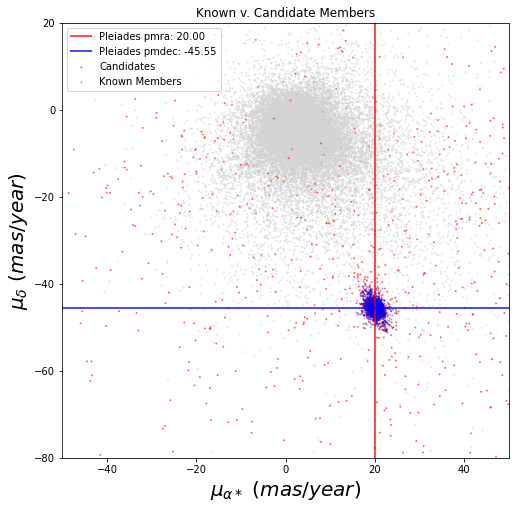

In [58]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

pmra = cluster_info.loc['Pleiades']['pmra']
pmdec = cluster_info.loc['Pleiades']['pmdec']
ax.axvline(pmra, color='red', lw=2,#ls=':',
              label=f'Pleiades pmra: {pmra:.2f}', alpha=0.7)
ax.axhline(pmdec, color='blue', lw=2,#ls='-',
              label=f'Pleiades pmdec: {pmdec:.2f}', alpha=0.7)

cb = ax.scatter(x='pmra',y='pmdec',s=1, data=pleiades_fs.objs, alpha=0.5,
                   facecolor=pleiades_fs.objs.labels.apply(color_lambda),
               label='Candidates')

ax.scatter(x='pmra',y='pmdec', s=1, data=pleiades_gaia.objs, alpha=0.3, color='blue',
          label='Known Members')

ax.set_xlabel(r'$\mu_{\alpha *}\ (mas/year)$',fontsize=20)
ax.set_ylabel(r'$\mu_{\delta}\ (mas/year)$', fontsize=20)

ax.set_ylim(-80,20)
ax.set_xlim(-50,50)
ax.set_title('Known v. Candidate Members')
ax.legend(loc='upper left')


## Model Summary

In [59]:
pleiades_all_coords = pleiades_all.get_coords()
#use cartesian coords along with PMs as feature matrix
feats_all = np.array([pleiades_all_coords.cartesian.x,
                  pleiades_all_coords.cartesian.y,
                  pleiades_all_coords.cartesian.z,
                  pleiades_all.objs.pmra,
                  pleiades_all.objs.pmdec]).T
pleiades_all.objs['labels'] = gmm.predict(feats_all)

In [60]:
# set fitted and true membership status
pleiades_all.objs['Member_hat'] = np.where(pleiades_all.objs.labels == pleiades_clust_id, 1, 0)
pleiades_all.objs['Member_true'] = np.where(np.logical_or(pleiades_all.objs.which == 'Pleiades: Known Members', pleiades_all.objs.which== 'both'), 1, 0)

In [61]:
from sklearn.metrics import confusion_matrix

In [62]:
#compute confusion matrix over just the stars that showed up in our query:
pleiades_q = pleiades_all.objs.query('which in [\'Pleiades: Field Stars\', \'both\']')
cm = confusion_matrix(pleiades_q.Member_true, pleiades_q.Member_hat)

In [63]:
confusion_matrix(pleiades_q.Member_true, pleiades_q.Member_hat)

array([[22683,  1114],
       [    0,   826]], dtype=int64)

In [64]:
# rearrange for plotting purposes and compute some summary stats
cm_df = pd.DataFrame(cm,
                     index = pd.Index(['Non-Member','Member'],name='Ground Truth'),
                     columns = pd.Index(['Non-Member','Member'],name='Predicted Class'))
acc = (cm[0,0]+cm[1,1])/cm.sum() # accuracy
prec = cm[1,1]/(cm[0,1]+cm[1,1]) #precision
rec = cm[1,1]/(cm[1,0]+cm[1,1])  #recall
                     

In [65]:
cm_df

Predicted Class,Non-Member,Member
Ground Truth,,
Non-Member,22683,1114
Member,0,826


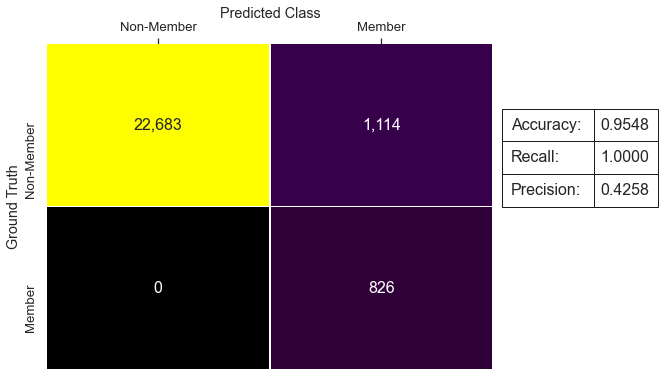

In [66]:
fig = plt.figure(figsize=(8,6))
sns.set(font_scale=1.2) # for label size
ax = sns.heatmap(cm_df, annot=True, annot_kws={"size": 16}, cmap='gnuplot', fmt=',.0f', cbar=False,
          linewidths=0.5) # font size
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

    
tab1=ax.table([['Accuracy:',f'{acc:.4f}'],['Recall:',f'{rec:.4f}'],['Precision:',f'{prec:.4f}']],
          cellLoc='left',
          edges='closed',
          bbox=[1.02,0.5,0.35,0.3],
         )

tab1.auto_set_column_width([0,1])
tab1.set_fontsize(16)

## Conclusions

Mixture model successully identifies all of the stars in the field of view that are members of the Pleiades, however it misclassifies an unacceptably high numbers of non-members as being members (false positives).

This lack of precision might be improved in the following ways:
- projecting stars' proper motions to the assumed cluster center's coordinates
- introduction of other astrometric or photometric measures in mixture model
- larger number of components in the mixture model
- use of BayesianGaussianMixture model to determine optimal number of components



## Compare to Optical Image (needs work)

In [67]:
# the Seven Sisters?
# get the 20 brightest stars from the pleiades cluster group
top20 = pleiades_fs.objs.query('labels == @pleiades_clust_id').sort_values('phot_g_mean_mag', ascending=True).iloc[0:20]

In [68]:
import urllib

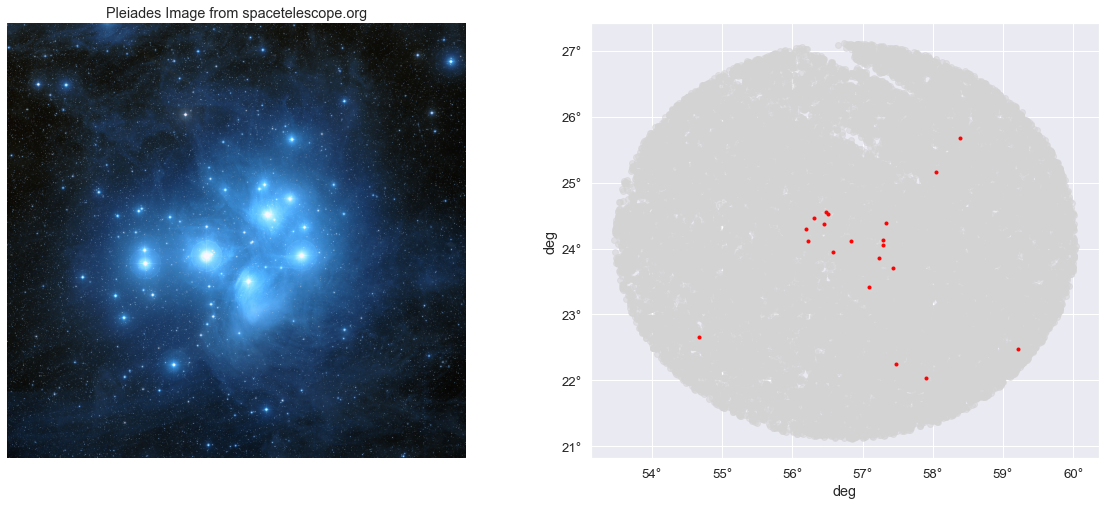

In [69]:
fig = plt.figure(figsize=(20,8))
ax = fig.subplots(1,2)

#plt.scatter(pleiades_coords.ra, pleiades_coords.dec,s=pleiades.objs.phot_g_mean_mag, alpha=0.5,c=pleiades.objs.labels.apply(color_lambda))
trans = ax[0].get_xaxis_transform()
f = urllib.request.urlopen('https://www.spacetelescope.org/static/archives/fitsimages/original/davidedemartin_5.jpg')
a = plt.imread(f, format='jpg')
ax[0].imshow(a)

ax[0].set_title('Pleiades Image from spacetelescope.org')
ax[0].set_xlabel('https://www.spacetelescope.org/static/archives/fitsimages/original/davidedemartin_5.jpg')
ax[0].set_xticks([])
ax[0].set_axis_off()

ax[1].scatter(pleiades_fs_coords.ra, pleiades_fs_coords.dec, color='lightgrey', alpha=0.5)
ax[1].scatter(top20.ra, top20.dec, s=9, color='red')